In [1]:
import gym
import seagul.envs
import pickle
import torch.utils.data

from seagul.rl.run_utils import load_model, load_workspace
import numpy as np
from numpy import pi
import matplotlib.pyplot as plt
from pprint import pprint
import pandas as pd
from seagul.rl.models import PPOModel, SwitchedPPOModel, SwitchedPPOModelActHold
from seagul.nn import MLP
#torch.set_default_dtype(torch.double)
dtype = np.float32

/home/sgillen/work/seagul/seagul/envs/__init__.py:107: UserWarning: Warning, registering environments for rllib failed!
  warnings.warn("Warning, registering environments for rllib failed!")


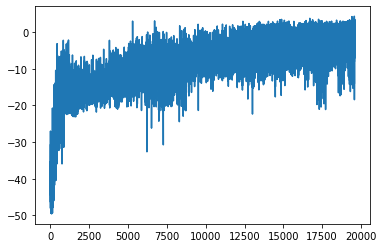

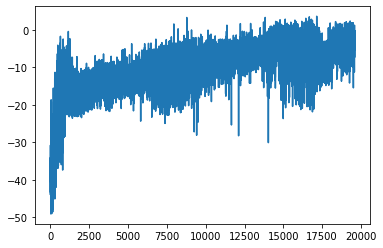

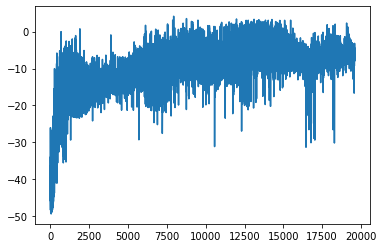

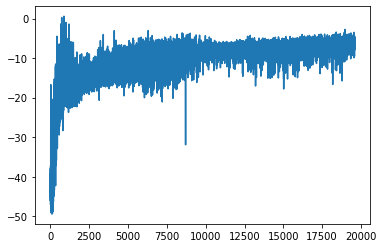

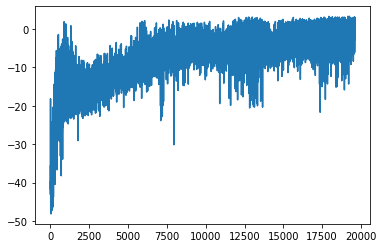

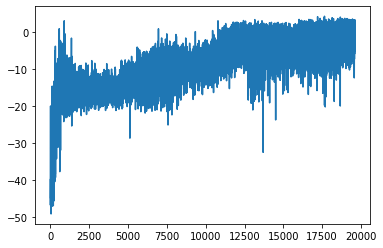

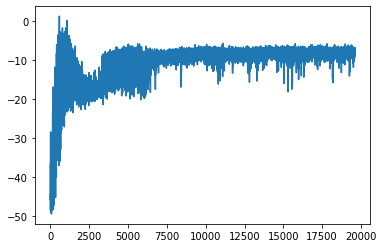

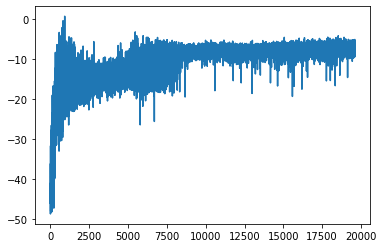

<Figure size 432x288 with 0 Axes>

In [96]:
import os
jup_dir = "/home/sgillen/work/"
directory = jup_dir + \
"seagul/seagul/notebooks/switching/data5_sac/trialsac_sin/"

#"seagul/seagul/notebooks/switching/data5_sac/trialtrial19/"


ws_list = []
model_list = []
for entry in os.scandir(directory):
            model, env, args, ws = load_workspace(entry.path)
            plt.plot(ws["raw_rew_hist"])
            plt.yscale
            
            
            plt.figure()
            ws_list.append(ws)
            model_list.append(model)


(0, 8000)

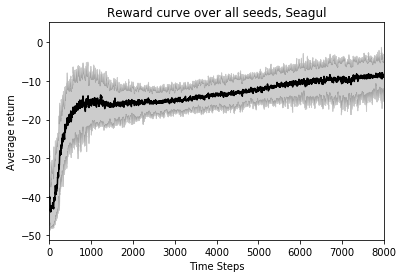

In [97]:
from seagul.plot import smooth_bounded_curve

rewards = np.zeros((len(ws["raw_rew_hist"]) + 1000, len(ws_list)))

for i,ws in enumerate(ws_list):
    #plt.plot(ws["raw_rew_hist"])
    #plt.figure()
    #print(len(ws["raw_rew_hist"]))

    rewards[:len(ws["raw_rew_hist"]),i] = np.array(ws["raw_rew_hist"])
    
fig, ax = smooth_bounded_curve(rewards,window=10)  
ax.set_title('Reward curve over all seeds, Seagul')
ax.set_xlim(0, 8000)
#ws = ws_list[0]
#model = model_list[0]

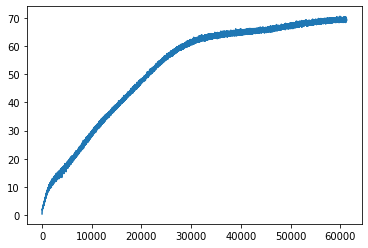

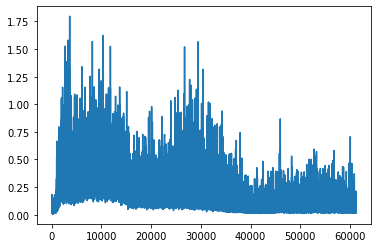

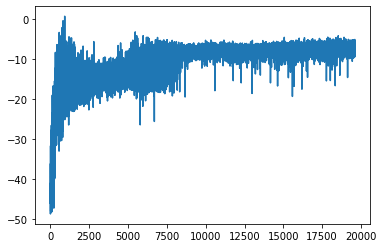

In [98]:
ws=ws_list[-1]
model = model_list[-1]

plt.plot(ws['pol_loss_hist'])
plt.figure()
plt.plot(ws['val_loss_hist'])
plt.figure()
plt.plot(ws['raw_rew_hist'])

In [ ]:
#torch.save(model.value_fn, open('./warm/ppo2_warm_valh2','wb'))
#torch.save(model.policy, open('./warm/ppo2_warm_polh2','wb'))

In [3]:
#model.value_fn.state_dict()


In [122]:
env = gym.make(ws['env_name'], **ws['env_config'])
max_torque = ws['env_config']['max_torque']

action_hist = np.zeros((env.num_steps,1))
state_hist = np.zeros((env.num_steps, env.observation_space.shape[0]))
reward_hist = np.zeros((env.num_steps, 1))
logp_hist = np.zeros((env.num_steps, 1))
gate_mean = np.zeros((env.num_steps,1))
means_hist = np.zeros((env.num_steps,1))
obs = env.reset()

for _ in range(1):
    torch.random.seed()
    obs = env.reset()
    lqr_on = False
    for i in range(env.num_steps):
        #env.lqr_on = True
        obs = torch.as_tensor(obs, dtype=torch.float32)

        actions, _, _, logp = model.step(obs.reshape(1,-1))
        actions = actions.detach()
        #actions, logp = model.select_action(obs)
    
        actions = np.clip(actions, -max_torque, max_torque)
        actions = torch.as_tensor(actions, dtype=torch.float32)
        obs, reward, done, _ = env.step(actions.detach().numpy())

        #env.render()
        action_hist[i,:] = np.copy(actions.detach())
        state_hist[i,:] = np.copy(obs)
        reward_hist[i,:] = np.copy(reward)

        try:
            logp_hist[i,:]   = np.copy(logp.detach())
        except:
            logp_hist[i,:]   = np.copy(logp)

        #means_hist[i, :] = np.copy(means.detach())
        
        if done:
            break
    print(sum(reward_hist))
    print(lqr_on)

[-5.90143015]
False


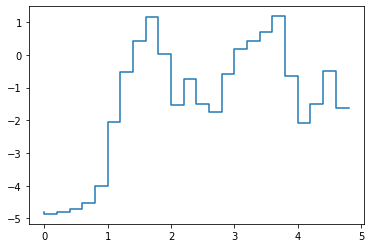

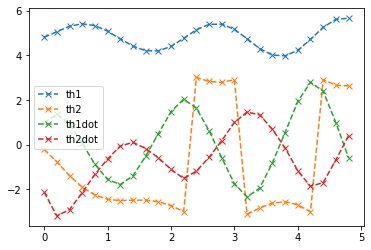

In [123]:
t = np.array([i*env.dt*env.act_hold for i in range(action_hist.shape[0])])

plt.step(t, action_hist)
plt.figure()
plt.plot(t, state_hist, 'x--')
plt.legend(['th1', 'th2', 'th1dot', 'th2dot'])



[-5.90143015]


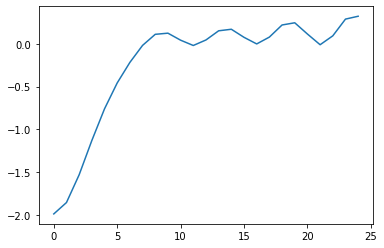

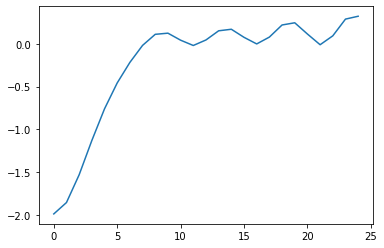

In [124]:
print(sum(reward_hist))
plt.plot(reward_hist)
plt.figure()
plt.plot((np.sin(state_hist[:,0]) + np.sin(state_hist[:,0] + state_hist[:,1])))\

<Figure size 432x288 with 0 Axes>

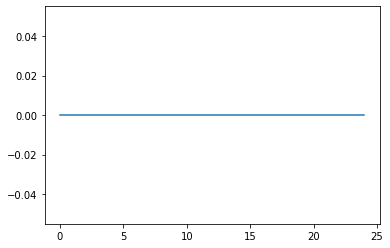

<Figure size 432x288 with 0 Axes>

In [94]:
plt.plot(means_hist)
plt.figure()

In [ ]:
env = gym.make('su_acro_drake-v0')

env.num_steps = 500

def control(q):
    k =  np.array([1316.85, 555.42, 570.33, 272.58])
    k =  np.array([[1594.02251358,  434.18754223,  294.66014026,   31.78222056]])
    k = np.array([[204.06707408,  59.21086694,  37.41566423,   5.29518038]])

    #k = np.array([[278.44223126, 112.29125985, 119.72457377,  56.82824017]])
    #k = np.array([[10.44, 3.561, 2.778, 1.301]])
    #k = 
    #import ipdb; ipdb.set_trace()
    gs = np.array([0,0,0,0])
    #return 0
    return -k.dot(gs - q)

action_hist = np.zeros((env.num_steps,1))
state_hist = np.zeros((env.num_steps, env.observation_space.shape[0]))
reward_hist = np.zeros((env.num_steps, 1))
path_hist = np.zeros((env.num_steps,1))


obs = env.reset(init_vec = [0,0,0,0]) 

import time
start = time.time()
for i in range(env.num_steps):
        #if(pi - 0.2 < obs[0] < pi+ 0.2 and -0.5 < obs[1] < 0.5): #and abs(obs[2]) < 1 and abs(obs[3] < 1)):
        #    actions = np.clip(np.asarray(control(obs)), -25,25)
        #    path_hist[i] = 1
        #else:
        #    actions, _, _, logp = model.step(torch.as_tensor(obs, dtype=torch.float32).reshape(1,-1))
        #    path_hist[i] = 0
        
        actions = np.clip(np.asarray(control(obs)), -1,1)

        actions =  np.clip(actions, -25, 25)
        actions = 0
        obs, reward, done, _ = env.step(actions)
        action_hist[i,:] = np.copy(actions)
        state_hist[i,:] = np.copy(obs)
        reward_hist[i,:] = np.copy(reward)
       # if done:
       #     break
            
print("total", time.time() - start)

plt.plot(action_hist)
plt.title('action hist')

plt.figure()
plt.plot(path_hist)
plt.title('path hist')

plt.figure()
plt.plot(reward_hist)
plt.title('reward hist')

plt.figure()
plt.plot(state_hist[:,0])
plt.title("theta 1")

plt.figure()
plt.plot(state_hist[:,1])
plt.title("theta 2")

plt.figure()
plt.plot(state_hist[:,2])
plt.title("theta1 dot")

plt.figure()
plt.plot(state_hist[:,3])
plt.title("theta 2 dot ")

print(sum(reward_hist))

In [ ]:
from seagul.plot import smooth_bounded_curve

hp_str = "max_torque"
hp_vals = [1,5,25,100]
seeds = [0,1]

num_seeds = 2
num_hp = 4
rewards = np.zeros((len(ws["raw_rew_hist"]), num_seeds, num_hp))

for ws in ws_list:
    hp = hp_vals.index(ws['env_config'][hp_str])
    seed = seeds.index(ws['seed'])
    rewards[:,seed, hp] = np.array(ws["raw_rew_hist"])



fig, axs = plt.subplots(4, 1,sharey =True, figsize=(15,25))

for i,hp in enumerate(hp_vals):
    smooth_bounded_curve(rewards[:,:,i], axs[i])
    
axs[0].set_title('Reward curve, ' + hp_str + " " + str(hp_vals[0]))
axs[1].set_title('Reward curve, ' + hp_str + " " + str(hp_vals[1]))
axs[2].set_title('Reward curve, ' + hp_str + " " + str(hp_vals[2]))
axs[3].set_title('Reward curve, ' + hp_str + " " + str(hp_vals[3]))
